# Geospatial research


In [ ]:
%pip install geopandas
%pip install geopy
%pip install matplotlib

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString

# Sample events dataframe (flatten your JSON into pandas DataFrame)
data = {
    'id': [1, 2],
    'title': ["Padua Food & Drink Event #1", "San Donà di Piave Arts & Crafts Event #2"],
    'latitude': [45.4077172, 45.6294811],
    'longitude': [11.8734455, 12.5641057],
    # add other fields as needed
}

df = pd.DataFrame(data)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf.set_crs(epsg=4326, inplace=True)  # WGS84 lat/lon

# Suppose you have a route as a LineString between Vicenza and Padua
route_coords = [(11.546699, 45.545932), (11.8734455, 45.4077172)]  # (lon, lat) tuples
route_line = LineString(route_coords)
route_gdf = gpd.GeoSeries([route_line], crs="EPSG:4326")

# Reproject to metric CRS for buffering (meters)
gdf_m = gdf.to_crs(epsg=3857)
route_m = route_gdf.to_crs(epsg=3857)

# Create 1 km buffer around route
buffer = route_m.buffer(1000).iloc[0]

# Filter events within buffer polygon
events_in_buffer = gdf_m[gdf_m.geometry.within(buffer)]

# Convert filtered events back to lat/lon CRS for display
events_in_buffer_wgs = events_in_buffer.to_crs(epsg=4326)

print(events_in_buffer_wgs[['id', 'title', 'geometry']])


   id                        title                   geometry
0   1  Padua Food & Drink Event #1  POINT (11.87345 45.40772)


/tmp/ipykernel_29177/1274075854.py:23: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


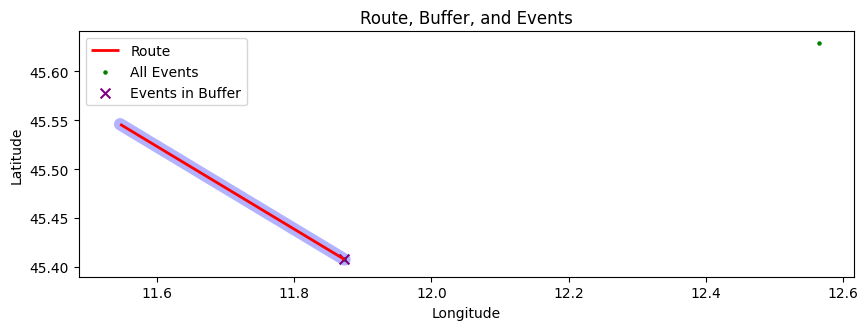

In [3]:
import matplotlib.pyplot as plt

# Plot the route and the buffer
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the route (converted back to WGS84 for plotting with events)
route_gdf.to_crs(epsg=4326).plot(ax=ax, color='red', linewidth=2, label='Route')

# Plot the buffer (converted back to WGS84 for plotting with events)
buffer_wgs = gpd.GeoSeries([buffer], crs=3857).to_crs(epsg=4326)
buffer_wgs.plot(ax=ax, color='blue', alpha=0.3, label='1km Buffer')

# Plot the events
gdf.to_crs(epsg=4326).plot(ax=ax, color='green', marker='o', markersize=5, label='All Events')

# Plot events within the buffer
events_in_buffer_wgs.plot(ax=ax, color='purple', marker='x', markersize=50, label='Events in Buffer')


ax.set_title("Route, Buffer, and Events")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()

### Query to qdrant of a route

In [8]:
import numpy as np
from shapely.geometry import LineString
from qdrant_client import QdrantClient
from qdrant_client.http import models as qmodels
import geopandas as gpd

import json
import os
from dotenv import load_dotenv
from qdrant_client import QdrantClient
from qdrant_client.http.models import PointStruct, VectorParams, Distance

load_dotenv(dotenv_path="../.env")

QDRANT_SERVER = os.getenv("QDRANT_SERVER")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")
COLLECTION_NAME = os.getenv("COLLECTION_NAME")

client = QdrantClient(
    url=QDRANT_SERVER,
    api_key=QDRANT_API_KEY,
    timeout=2000000
)

# 1. Define your route (lon, lat)
#route_coords = [(11.546699, 45.545932), (11.8834455, 45.4077172)]
route_coords = [
    #(11.546698, 45.545932),     # Vicenza
    #(11.6603917, 45.2254915),   # Este
    (11.8734458, 45.4077173),   # Padua
    (12.84052, 45.78071)        # Portogruaro
]



route_line = LineString(route_coords)

# 2. Buffer the route by 1km (1000 meters)
# Convert to a projected CRS for accurate buffering
route_gdf = gpd.GeoSeries([route_line], crs="EPSG:4326").to_crs(epsg=3857)
buffer_poly = route_gdf.buffer(30000).to_crs(epsg=4326).iloc[0]  # back to WGS84

# 3. Get polygon coordinates for Qdrant (as [lon, lat] lists)
polygon_coords = np.array(buffer_poly.exterior.coords).tolist()

# 4. Convert polygon coords to [{"lon": lon, "lat": lat}, ...] format for Qdrant
polygon_coords_qdrant = [{"lon": lon, "lat": lat} for lon, lat in polygon_coords]
# 5. Connect to Qdrant

# 6. Build geo filter for Qdrant using GeoLineString wrapper for exterior


from qdrant_client.http import models as qmodels

#startinputdate = "2025-08-23T10:04:00Z"
#endinputdate = "2025-08-23T10:19:00Z"

startinputdate = "2025-10-29T08:54:00Z"
endinputdate = "2025-11-29T09:56:00Z"



geo_filter = qmodels.Filter(
    must=[
        qmodels.FieldCondition(
            key="location",
            geo_polygon=qmodels.GeoPolygon(
                exterior=qmodels.GeoLineString(points=polygon_coords_qdrant)
            )
        )
    ]
)

# Date filters for start_date and end_date inside input range
start_date_filter = qmodels.Filter(
    must=[
        qmodels.FieldCondition(
            key="start_date",
            range=qmodels.DatetimeRange(
            gte=startinputdate,
            lte=endinputdate,
            )
        )
    ]
)        

# Date filters for start_date and end_date inside input range
end_date_filter = qmodels.Filter(
    must=[
        qmodels.FieldCondition(
            key="end_date",
            range=qmodels.DatetimeRange(
            gte=startinputdate,
            lte=endinputdate,
            )
        )
    ]
)        



# Combine date filters with OR
date_filter = qmodels.Filter(
    should=[
        start_date_filter,
        end_date_filter
    ],
    #min_should_match=1
)

date_intersection_filter = qmodels.Filter(
    must=[
        qmodels.FieldCondition(
            key="start_date",
            range=qmodels.DatetimeRange(
                lte=endinputdate
            )
        ),
        qmodels.FieldCondition(
            key="end_date",
            range=qmodels.DatetimeRange(
                gte=startinputdate
            )
        )
    ]
)

# Final combined filter: must be inside geo polygon AND start_date OR end_date in range
final_filter = qmodels.Filter(
    must=[
        geo_filter,
        date_intersection_filter #date_filter
    ]
)



# 7. Query Qdrant (returns points inside the polygon)
results = client.query_points(
    collection_name=COLLECTION_NAME, #"veneto_events",
    limit=100,
    query_filter=final_filter,#start_date_filter,#geo_filter,   # your qmodels.Filter instance
    with_payload=True          # include full payload in results
)
#print(results)
# 8. Print results
import pandas as pd



#print(f"polygon con buffer",polygon_coords_qdrant)

# Extract payloads from points
payloads = [point.payload for point in results.points]

# Create a DataFrame directly from the list of payload dictionaries
df = pd.json_normalize(payloads)  # This flattens nested dictionaries into columns

# Show the DataFrame
df



,id,title,category,description,city,start_date,end_date,url,hash,location.venue,location.address,location.latitude,location.longitude,location.lat,location.lon
0,0adb38c0-5782-4e7a-b3f9-542d791dda75_2025-11-08,Antica Fiera di San Martino,Enogastronomia,Antica Fiera di San Martino 2025 a Piazzola su...,Piazzola sul Brenta,2025-11-08T00:00:00,2025-11-08T23:59:59Z,https://www.unpliveneto.it/eventi-delle-pro-lo...,590b6b95b4467172024a5cd770fed844f1e882c5e9f97f...,centro cittadino,"centro cittadino, Piazzola sul Brenta",45.542421,11.786113,45.542421,11.786113
1,0adb38c0-5782-4e7a-b3f9-542d791dda75_2025-11-10,Antica Fiera di San Martino,Enogastronomia,Antica Fiera di San Martino 2025 a Piazzola su...,Piazzola sul Brenta,2025-11-10T00:00:00,2025-11-10T23:59:59Z,https://www.unpliveneto.it/eventi-delle-pro-lo...,590b6b95b4467172024a5cd770fed844f1e882c5e9f97f...,centro cittadino,"centro cittadino, Piazzola sul Brenta",45.542421,11.786113,45.542421,11.786113
2,0adb38c0-5782-4e7a-b3f9-542d791dda75_2025-11-09,Antica Fiera di San Martino,Enogastronomia,Antica Fiera di San Martino 2025 a Piazzola su...,Piazzola sul Brenta,2025-11-09T00:00:00,2025-11-09T23:59:59Z,https://www.unpliveneto.it/eventi-delle-pro-lo...,590b6b95b4467172024a5cd770fed844f1e882c5e9f97f...,centro cittadino,"centro cittadino, Piazzola sul Brenta",45.542421,11.786113,45.542421,11.786113
3,0adb38c0-5782-4e7a-b3f9-542d791dda75_2025-11-14,Antica Fiera di San Martino,Enogastronomia,Antica Fiera di San Martino 2025 a Piazzola su...,Piazzola sul Brenta,2025-11-14T00:00:00,2025-11-14T23:59:59Z,https://www.unpliveneto.it/eventi-delle-pro-lo...,590b6b95b4467172024a5cd770fed844f1e882c5e9f97f...,centro cittadino,"centro cittadino, Piazzola sul Brenta",45.542421,11.786113,45.542421,11.786113
4,0adb38c0-5782-4e7a-b3f9-542d791dda75_2025-11-11,Antica Fiera di San Martino,Enogastronomia,Antica Fiera di San Martino 2025 a Piazzola su...,Piazzola sul Brenta,2025-11-11T00:00:00,2025-11-11T23:59:59Z,https://www.unpliveneto.it/eventi-delle-pro-lo...,590b6b95b4467172024a5cd770fed844f1e882c5e9f97f...,centro cittadino,"centro cittadino, Piazzola sul Brenta",45.542421,11.786113,45.542421,11.786113
5,0adb38c0-5782-4e7a-b3f9-542d791dda75_2025-11-13,Antica Fiera di San Martino,Enogastronomia,Antica Fiera di San Martino 2025 a Piazzola su...,Piazzola sul Brenta,2025-11-13T00:00:00,2025-11-13T23:59:59Z,https://www.unpliveneto.it/eventi-delle-pro-lo...,590b6b95b4467172024a5cd770fed844f1e882c5e9f97f...,centro cittadino,"centro cittadino, Piazzola sul Brenta",45.542421,11.786113,45.542421,11.786113
6,649e8b6b-dac6-45fe-b23f-3e4005d6c1d8_2025-11-08,Villa Cornaro - Il Palladio e i Sapori del Ter...,,"Visita guidata a Villa Cornaro, capolavoro pal...",Piombino Dese,2025-11-08T15:00:00,2025-11-08T23:59:59Z,https://www.unpliveneto.it/eventi-delle-pro-lo...,dffee7767220908aba115467adf0e4e5c3e12c23a949fb...,Villa Cornaro,"Villa Cornaro, Piombino Dese",45.607294,11.999397,45.607294,11.999397
7,0adb38c0-5782-4e7a-b3f9-542d791dda75_2025-11-16,Antica Fiera di San Martino,Enogastronomia,Antica Fiera di San Martino 2025 a Piazzola su...,Piazzola sul Brenta,2025-11-16T00:00:00,2025-11-16T23:59:59Z,https://www.unpliveneto.it/eventi-delle-pro-lo...,590b6b95b4467172024a5cd770fed844f1e882c5e9f97f...,centro cittadino,"centro cittadino, Piazzola sul Brenta",45.542421,11.786113,45.542421,11.786113
8,0adb38c0-5782-4e7a-b3f9-542d791dda75_2025-11-15,Antica Fiera di San Martino,Enogastronomia,Antica Fiera di San Martino 2025 a Piazzola su...,Piazzola sul Brenta,2025-11-15T00:00:00,2025-11-15T23:59:59Z,https://www.unpliveneto.it/eventi-delle-pro-lo...,590b6b95b4467172024a5cd770fed844f1e882c5e9f97f...,centro cittadino,"centro cittadino, Piazzola sul Brenta",45.542421,11.786113,45.542421,11.786113
9,0adb38c0-5782-4e7a-b3f9-542d791dda75_2025-11-12,Antica Fiera di San Martino,Enogastronomia,Antica Fiera di San Martino 2025 a Piazzola su...,Piazzola sul Brenta,2025-11-12T00:00:00,2025-11-12T23:59:59Z,https://www.unpliveneto.it/eventi-d

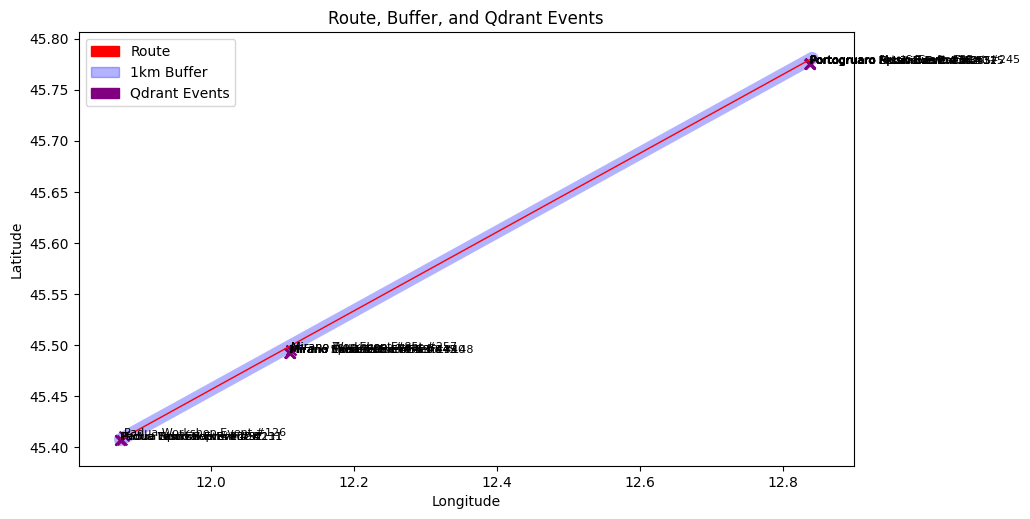

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.patches as mpatches

# Collect Qdrant results into a GeoDataFrame
event_points = []
titles = []
for point in results.points:
    loc = point.payload.get("location", {})
    lat = loc.get("lat")
    lon = loc.get("lon")
    if lat is not None and lon is not None:
        event_points.append(Point(lon, lat))
        titles.append(point.payload.get("title", ""))

if event_points:
    gdf_qdrant = gpd.GeoDataFrame({"title": titles, "geometry": event_points}, crs="EPSG:4326")
else:
    gdf_qdrant = gpd.GeoDataFrame(columns=["title", "geometry"], crs="EPSG:4326")

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the route (no label here)
gpd.GeoSeries([route_line], crs="EPSG:4326").plot(ax=ax, color='red', linewidth=1)

# Plot the buffer (no label here)
gpd.GeoSeries([buffer_poly], crs="EPSG:4326").plot(ax=ax, color='blue', alpha=0.3)

# Plot Qdrant events
if not gdf_qdrant.empty:
    gdf_qdrant.plot(ax=ax, color='purple', marker='x', markersize=50)
    # Optionally, add event titles
    for idx, row in gdf_qdrant.iterrows():
        ax.text(row.geometry.x, row.geometry.y, row.title, fontsize=8, color='black')
else:
    print("No events found in Qdrant for this buffer.")

# Manually create legend patches
route_patch = mpatches.Patch(color='red', label='Route')
buffer_patch = mpatches.Patch(color='blue', alpha=0.3, label='1km Buffer')
events_patch = mpatches.Patch(color='purple', label='Qdrant Events')
ax.legend(handles=[route_patch, buffer_patch, events_patch])

ax.set_title("Route, Buffer, and Qdrant Events")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

## I want to use Openstreetmap to create a real route

In [ ]:
%pip install osmnx

MultiDiGraph with 9944 nodes and 21419 edges
stampato G
325074361 9416572746
[325074361, 5001672068, 10819852393, 12559101771, 618643804, 618643777, 330196737, 330196268, 247911074, 1459121943, 330195233, 247906863, 330198013, 194420355, 254931559, 254931563, 254931550, 1544008135, 254931535, 254931536, 10315488615, 254931539, 254931542, 254931518, 517735773, 518014388, 517735726, 517735874, 517735554, 6697056271, 485924926, 243517142, 2310870131, 243517135, 256071918, 1834754045, 207094142, 7049685181, 255896874, 256071993, 256072058, 256072265, 762596339, 1132461607, 207093931, 521993247, 249442832, 249442864, 207096137, 210472874, 207094123, 12032040918, 465624031, 482256329, 482256334, 482256321, 729308457, 207096139, 2517681265, 263675896, 263675895, 729308463, 689585569, 729308491, 11252603899, 729308444, 729308551, 729308415, 729308494, 762106941, 677697786, 471611082, 729308468, 729308516, 729308545, 761251612, 687518445, 687518477, 260772863, 419383882, 415488489, 3936675385, 

<Axes: >

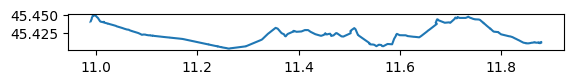

In [7]:
import osmnx as ox
from shapely.geometry import Polygon, LineString
import geopandas as gpd
import geopandas as gpd
import numpy as np
ox.settings.use_cache = True  # enable caching of HTTP requests

# Your origin and destination points (lat, lon) like (y,x)
#origin_point = (45.640317186277066, 12.241487413188237) # strada Terraglio TV
#destination_point = (45.68758465370057, 12.2562502911396) # prima di Selvana TV


origin_point = (45.41026004774276, 11.877749172855356) # Padova
destination_point = (45.44013878631641, 10.989916584327693) # Verona
#origin_point = (45.4109553303283, 11.883520063045811) # Padova (PD)
#destination_point = (45.55564536495325, 11.543093946961582) # Vicenza (VI)

#destination_point = (45.45795667928977, 10.982370142567046) # Verona (VR)
#origin_point = (45.5063774869007, 10.73446566988937) # Lazise (VR)
#destination_point =(45.43848433719987, 10.969985064989903) # Verona (VR)

# Create bounding box polygon covering both points
min_lat = min(origin_point[0], destination_point[0])
max_lat = max(origin_point[0], destination_point[0])
min_lon = min(origin_point[1], destination_point[1])
max_lon = max(origin_point[1], destination_point[1])

bbox_polygon = Polygon([
    (min_lon, min_lat),  # southwest
    (min_lon, max_lat),  # northwest
    (max_lon, max_lat),  # northeast
    (max_lon, min_lat),  # southeast
    (min_lon, min_lat)   # close polygon
])

from shapely.geometry import Polygon
bbox_polygon = bbox_polygon.buffer(0.01)  # buffer about 1 km depending on coordinates

# Download drivable road network within this polygon
G = ox.graph_from_polygon(bbox_polygon, network_type='drive', retain_all=True)
print(G)
print("stampato G")
# Find nearest nodes to origin and destination points in graph (lon, lat)
origin_node = ox.distance.nearest_nodes(G, origin_point[1], origin_point[0],return_dist=False)
destination_node = ox.distance.nearest_nodes(G, destination_point[1], destination_point[0],return_dist=False)
print(origin_node,destination_node)
#origin_node=247910834
#destination_node=530212898

# Compute shortest path by length
#route = ox.shortest_path(G, origin_node, destination_node, weight='length')
route = ox.shortest_path(G, origin_node, destination_node, weight='length')
print(route)


# Extract node coordinates for route geometry
route_coords = [(G.nodes[n]['x'], G.nodes[n]['y']) for n in route]

# Create a LineString for the route
route_line = LineString(route_coords)

# Create GeoDataFrame for route
route_gdf = gpd.GeoDataFrame([{'geometry': route_line}], crs='EPSG:4326')

# Convert to projected CRS for buffering
route_gdf_3857 = route_gdf.to_crs(epsg=3857)
buffer_poly = route_gdf_3857.buffer(1000).to_crs(epsg=4326).iloc[0]

# Extract polygon coordinates for Qdrant filter
polygon_coords = np.array(buffer_poly.exterior.coords).tolist()
polygon_coords_qdrant = [{"lon": lon, "lat": lat} for lon, lat in polygon_coords]

print(polygon_coords_qdrant)

# Plot the route
route_gdf.plot()


In [8]:
from qdrant_client.http import models as qmodels
import geopandas as gpd

import json
import os
from dotenv import load_dotenv
from qdrant_client import QdrantClient
from qdrant_client.http.models import PointStruct, VectorParams, Distance


load_dotenv(dotenv_path="../.env")

QDRANT_SERVER = os.getenv("QDRANT_SERVER")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")

client = QdrantClient(
    url=QDRANT_SERVER,
    api_key=QDRANT_API_KEY,
    timeout=2000000
)



# 6. Build geo filter for Qdrant using GeoLineString wrapper for exterior
geo_filter = qmodels.Filter(
    must=[
        qmodels.FieldCondition(
            key="location",  # or "geo" if that is your geo field name
            geo_polygon=qmodels.GeoPolygon(
                exterior=qmodels.GeoLineString(points=polygon_coords_qdrant)
            )
        )
    ]
)

# 7. Query Qdrant (returns points inside the polygon)
results = client.query_points(
    collection_name="veneto_events",
    limit=100,
    query_filter=geo_filter,   # your qmodels.Filter instance
    with_payload=True          # include full payload in results
)
#print(results)
# 8. Print results
import pandas as pd


print(polygon_coords_qdrant)
# Extract payloads from points
payloads = [point.payload for point in results.points]

# Create a DataFrame directly from the list of payload dictionaries
df = pd.json_normalize(payloads)  # This flattens nested dictionaries into columns

# Show the DataFrame
df



[{'lon': 10.982690964498163, 'lat': 45.446019957239905}, {'lon': 10.982708724873008, 'lat': 45.44620453816914}, {'lon': 10.982847288930863, 'lat': 45.44679683765832}, {'lon': 10.983065537414978, 'lat': 45.44737719706735}, {'lon': 10.983411637414978, 'lat': 45.44814687119577}, {'lon': 10.983678877661323, 'lat': 45.44866193701848}, {'lon': 10.984008901857294, 'lat': 45.44915875944199}, {'lon': 10.98479420120221, 'lat': 45.450218020715845}, {'lon': 10.984806168996679, 'lat': 45.45026183441387}, {'lon': 10.984973925748266, 'lat': 45.45076388390696}, {'lon': 10.98500182574827, 'lat': 45.450834281799985}, {'lon': 10.985372006673646, 'lat': 45.4515825183109}, {'lon': 10.985493006673646, 'lat': 45.45178500956397}, {'lon': 10.9858812214236, 'lat': 45.45235319681916}, {'lon': 10.986348378025367, 'lat': 45.452891343202644}, {'lon': 10.986889806269707, 'lat': 45.45339406974718}, {'lon': 10.987500093446654, 'lat': 45.45385635165833}, {'lon': 10.988173138456922, 'lat': 45.45427356850738}, {'lon': 10

,id,title,category,description,city,start_date,end_date,url,hash,location.venue,location.address,location.latitude,location.longitude,location.lat,location.lon
0,10,Verona Arts & Crafts Event #10,Arts & Crafts,Immerse yourself in the rich culture of Verona...,Verona,2025-09-18T03:23:00Z,2025-09-18T09:23:00Z,https://example.com/veneto-events/10,1fb3596c7adbbf0c7a1e155fa84b658a6898c1c1ba4984...,Santa Anastasia Church,"Santa Anastasia Church, Verona, Veneto",45.438496,10.992412,45.438496,10.992412
1,111,Padua Exhibition Event #111,Exhibition,Immerse yourself in the rich culture of Padua ...,Padua,2025-09-26T19:57:00Z,2025-09-27T04:57:00Z,https://example.com/veneto-events/111,ec4b22948e65b96db7b4a06f780ea03252347c37768648...,Abbazia di Santa Giustina,"Abbazia di Santa Giustina, Padua, Veneto",45.407717,11.873446,45.407717,11.873446
2,208,Verona Workshop Event #208,Workshop,Dive into the world of workshop at this exciti...,Verona,2025-08-31T17:02:00Z,2025-09-01T01:02:00Z,https://example.com/veneto-events/208,65cf79d783d6a58e57c6a13a1da08e61fd32b91441c010...,Torre dei Lamberti,"Torre dei Lamberti, Verona, Veneto",45.438496,10.992412,45.438496,10.992412
3,91,Padua Festival Event #91,Festival,Explore the vibrant festival scene in Padua wi...,Padua,2025-09-27T17:08:00Z,2025-09-28T01:08:00Z,https://example.com/veneto-events/91,7915ee163dd971efa6dab07dc161211734497c0e35b679...,Museo Antoniano,"Museo Antoniano, Padua, Veneto",45.407717,11.873446,45.407717,11.873446
4,231,Padua Workshop Event #231,Workshop,Prepare for an unforgettable workshop experien...,Padua,2025-09-27T22:16:00Z,2025-09-28T00:16:00Z,https://example.com/veneto-events/231,41a0d445ff861968d063d2cd6c8d5324f38941f08b813e...,Civic Museum,"Civic Museum, Padua, Veneto",45.407717,11.873446,45.407717,11.873446
5,126,Padua Workshop Event #126,Workshop,Explore the vibrant workshop scene in Padua wi...,Padua,2025-09-02T19:17:00Z,2025-09-02T23:17:00Z,https://example.com/veneto-events/126,2c2039eaf9d474957baca8bd38e51bcdc9d2721797c20d...,Museo Bottacin,"Museo Bottacin, Padua, Veneto",45.411432,11.878154,45.411432,11.878154
6,198,Padua Sport Event #198,Sport,Connect with fellow enthusiasts at this lively...,Padua,2025-09-09T20:27:00Z,2025-09-09T23:27:00Z,https://example.com/veneto-events/198,76d78442f73ada62b7820fec2e6d22b6cfcb28208a1a8e...,Piazza delle Erbe,"Piazza delle Erbe, Padua, Veneto",45.406932,11.875273,45.406932,11.875273
7,37,Padua Festival Event #37,Festival,Expand your horizons with this insightful fest...,Padua,2025-09-11T17:16:00Z,2025-09-12T01:16:00Z,https://example.com/veneto-events/37,d610fe687a16741994be38c52d9a5d738c5df039b516dc...,Museo del Precinema,"Museo del Precinema, Padua, Veneto",45.407717,11.873446,45.407717,11.873446
8,307,Padua Tour Event #307,Tour,Immerse yourself in the rich culture of Padua ...,Padua,2025-09-22T14:39:00Z,2025-09-22T23:39:00Z,https://example.com/veneto-events/307,f8a0703b3a784c14006b22da06e67de50dd35a5fcfeb45...,Civic Museum,"Civic Museum, Padua, Veneto",45.407717,11.873446,45.407717,11.873446


/tmp/ipykernel_29177/1829689547.py:37: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


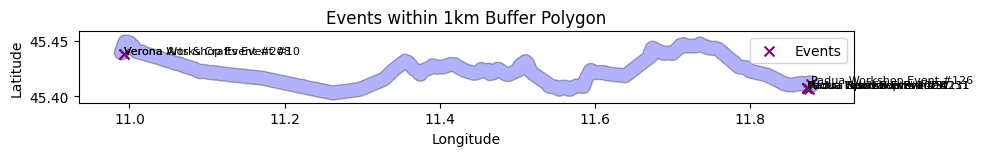

In [9]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# Build gdf_qdrant from Qdrant results if not already defined
event_points = []
titles = []
for point in results.points:
    loc = point.payload.get("location", {})
    lat = loc.get("lat")
    lon = loc.get("lon")
    if lat is not None and lon is not None:
        event_points.append(Point(lon, lat))
        titles.append(point.payload.get("title", ""))

if event_points:
    gdf_qdrant = gpd.GeoDataFrame({"title": titles, "geometry": event_points}, crs="EPSG:4326")
else:
    gdf_qdrant = gpd.GeoDataFrame(columns=["title", "geometry"], crs="EPSG:4326")

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the buffer polygon
gpd.GeoSeries([buffer_poly], crs="EPSG:4326").plot(ax=ax, color='blue', alpha=0.3, edgecolor='black', label='1km Buffer')

# Plot the events inside the buffer
if not gdf_qdrant.empty:
    gdf_qdrant.plot(ax=ax, color='purple', marker='x', markersize=50, label='Events')
    for idx, row in gdf_qdrant.iterrows():
        ax.text(row.geometry.x, row.geometry.y, row.title, fontsize=8, color='black')
else:
    print("No events found in Qdrant for this buffer.")

ax.set_title("Events within 1km Buffer Polygon")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()

In [ ]:
%pip install openrouteservice

In [10]:
import openrouteservice
from openrouteservice import convert
import os

from dotenv import load_dotenv

load_dotenv(dotenv_path="../.env")

OPENROUTE_API_KEY = os.getenv("OPENROUTE_API_KEY")


# Specify your personal API key here
api_key = OPENROUTE_API_KEY

# Initialize the client with your API key
client = openrouteservice.Client(key=api_key)

# Define coordinates as a list of longitude, latitude tuples
coords = [(8.34234, 48.23424), (8.34423, 48.26424)]

# Request directions for cycling-regular profile
routes = client.directions(coords, profile='cycling-regular', optimize_waypoints=True)

# Print the raw response
print(routes)

# Decode the polyline geometry to GeoJSON format
geometry = routes['routes'][0]['geometry']
decoded = convert.decode_polyline(geometry)

# Print decoded geometry
print(decoded)


/home/biso/development/my_projects/.venv/lib/python3.12/site-packages/openrouteservice/directions.py:202: UserWarning: Less than 4 coordinates, nothing to optimize!
  warnings.warn("Less than 4 coordinates, nothing to optimize!", UserWarning)


{'bbox': [8.327725, 48.233135, 8.345244, 48.263552], 'routes': [{'summary': {'distance': 5205.9, 'duration': 1305.3}, 'segments': [{'distance': 5205.9, 'duration': 1305.3, 'steps': [{'distance': 888.7, 'duration': 234.8, 'type': 11, 'instruction': 'Head southwest', 'name': '-', 'way_points': [0, 24]}, {'distance': 822.8, 'duration': 164.6, 'type': 5, 'instruction': 'Turn slight right onto Sulzbacher Straße, K 5528', 'name': 'Sulzbacher Straße, K 5528', 'way_points': [24, 52]}, {'distance': 263.7, 'duration': 59.3, 'type': 1, 'instruction': 'Turn right', 'name': '-', 'way_points': [52, 61]}, {'distance': 301.9, 'duration': 67.9, 'type': 0, 'instruction': 'Turn left', 'name': '-', 'way_points': [61, 73]}, {'distance': 535.6, 'duration': 118.0, 'type': 0, 'instruction': 'Turn left', 'name': '-', 'way_points': [73, 84]}, {'distance': 248.1, 'duration': 55.8, 'type': 13, 'instruction': 'Keep right', 'name': '-', 'way_points': [84, 92]}, {'distance': 286.6, 'duration': 73.7, 'type': 1, 'inst

## I chose openroute services because it is reliable, fast, and ok with api limits

In [13]:
from qdrant_client.http import models as qmodels
import geopandas as gpd

import json
import os
from dotenv import load_dotenv
from qdrant_client import QdrantClient
from qdrant_client.http.models import PointStruct, VectorParams, Distance


load_dotenv(dotenv_path="../.env")

QDRANT_SERVER = os.getenv("QDRANT_SERVER")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")

client = QdrantClient(
    url=QDRANT_SERVER,
    api_key=QDRANT_API_KEY,
    timeout=2000000
)



# 6. Build geo filter for Qdrant using GeoLineString wrapper for exterior
geo_filter = qmodels.Filter(
    must=[
        qmodels.FieldCondition(
            key="location",  # or "geo" if that is your geo field name
            geo_polygon=qmodels.GeoPolygon(
                exterior=qmodels.GeoLineString(points=polygon_coords_qdrant)
            )
        )
    ]
)

# 7. Query Qdrant (returns points inside the polygon)
results = client.query_points(
    collection_name="veneto_events",
    limit=100,
    query_filter=geo_filter,   # your qmodels.Filter instance
    with_payload=True          # include full payload in results
)
#print(results)
# 8. Print results
import pandas as pd


print(polygon_coords_qdrant)
# Extract payloads from points
payloads = [point.payload for point in results.points]

# Create a DataFrame directly from the list of payload dictionaries
df = pd.json_normalize(payloads)  # This flattens nested dictionaries into columns

# Show the DataFrame
df



[{'lon': 10.982690964498163, 'lat': 45.446019957239905}, {'lon': 10.982708724873008, 'lat': 45.44620453816914}, {'lon': 10.982847288930863, 'lat': 45.44679683765832}, {'lon': 10.983065537414978, 'lat': 45.44737719706735}, {'lon': 10.983411637414978, 'lat': 45.44814687119577}, {'lon': 10.983678877661323, 'lat': 45.44866193701848}, {'lon': 10.984008901857294, 'lat': 45.44915875944199}, {'lon': 10.98479420120221, 'lat': 45.450218020715845}, {'lon': 10.984806168996679, 'lat': 45.45026183441387}, {'lon': 10.984973925748266, 'lat': 45.45076388390696}, {'lon': 10.98500182574827, 'lat': 45.450834281799985}, {'lon': 10.985372006673646, 'lat': 45.4515825183109}, {'lon': 10.985493006673646, 'lat': 45.45178500956397}, {'lon': 10.9858812214236, 'lat': 45.45235319681916}, {'lon': 10.986348378025367, 'lat': 45.452891343202644}, {'lon': 10.986889806269707, 'lat': 45.45339406974718}, {'lon': 10.987500093446654, 'lat': 45.45385635165833}, {'lon': 10.988173138456922, 'lat': 45.45427356850738}, {'lon': 10

,id,title,category,description,city,start_date,end_date,url,hash,location.venue,location.address,location.latitude,location.longitude,location.lat,location.lon
0,10,Verona Arts & Crafts Event #10,Arts & Crafts,Immerse yourself in the rich culture of Verona...,Verona,2025-09-18T03:23:00Z,2025-09-18T09:23:00Z,https://example.com/veneto-events/10,1fb3596c7adbbf0c7a1e155fa84b658a6898c1c1ba4984...,Santa Anastasia Church,"Santa Anastasia Church, Verona, Veneto",45.438496,10.992412,45.438496,10.992412
1,111,Padua Exhibition Event #111,Exhibition,Immerse yourself in the rich culture of Padua ...,Padua,2025-09-26T19:57:00Z,2025-09-27T04:57:00Z,https://example.com/veneto-events/111,ec4b22948e65b96db7b4a06f780ea03252347c37768648...,Abbazia di Santa Giustina,"Abbazia di Santa Giustina, Padua, Veneto",45.407717,11.873446,45.407717,11.873446
2,208,Verona Workshop Event #208,Workshop,Dive into the world of workshop at this exciti...,Verona,2025-08-31T17:02:00Z,2025-09-01T01:02:00Z,https://example.com/veneto-events/208,65cf79d783d6a58e57c6a13a1da08e61fd32b91441c010...,Torre dei Lamberti,"Torre dei Lamberti, Verona, Veneto",45.438496,10.992412,45.438496,10.992412
3,91,Padua Festival Event #91,Festival,Explore the vibrant festival scene in Padua wi...,Padua,2025-09-27T17:08:00Z,2025-09-28T01:08:00Z,https://example.com/veneto-events/91,7915ee163dd971efa6dab07dc161211734497c0e35b679...,Museo Antoniano,"Museo Antoniano, Padua, Veneto",45.407717,11.873446,45.407717,11.873446
4,231,Padua Workshop Event #231,Workshop,Prepare for an unforgettable workshop experien...,Padua,2025-09-27T22:16:00Z,2025-09-28T00:16:00Z,https://example.com/veneto-events/231,41a0d445ff861968d063d2cd6c8d5324f38941f08b813e...,Civic Museum,"Civic Museum, Padua, Veneto",45.407717,11.873446,45.407717,11.873446
5,126,Padua Workshop Event #126,Workshop,Explore the vibrant workshop scene in Padua wi...,Padua,2025-09-02T19:17:00Z,2025-09-02T23:17:00Z,https://example.com/veneto-events/126,2c2039eaf9d474957baca8bd38e51bcdc9d2721797c20d...,Museo Bottacin,"Museo Bottacin, Padua, Veneto",45.411432,11.878154,45.411432,11.878154
6,198,Padua Sport Event #198,Sport,Connect with fellow enthusiasts at this lively...,Padua,2025-09-09T20:27:00Z,2025-09-09T23:27:00Z,https://example.com/veneto-events/198,76d78442f73ada62b7820fec2e6d22b6cfcb28208a1a8e...,Piazza delle Erbe,"Piazza delle Erbe, Padua, Veneto",45.406932,11.875273,45.406932,11.875273
7,37,Padua Festival Event #37,Festival,Expand your horizons with this insightful fest...,Padua,2025-09-11T17:16:00Z,2025-09-12T01:16:00Z,https://example.com/veneto-events/37,d610fe687a16741994be38c52d9a5d738c5df039b516dc...,Museo del Precinema,"Museo del Precinema, Padua, Veneto",45.407717,11.873446,45.407717,11.873446
8,307,Padua Tour Event #307,Tour,Immerse yourself in the rich culture of Padua ...,Padua,2025-09-22T14:39:00Z,2025-09-22T23:39:00Z,https://example.com/veneto-events/307,f8a0703b3a784c14006b22da06e67de50dd35a5fcfeb45...,Civic Museum,"Civic Museum, Padua, Veneto",45.407717,11.873446,45.407717,11.873446


## Update 26/08/2025
## Now I query with prefecthes and filter


In [1]:
#import pandas as pd
import openrouteservice
#from qdrant_client.models import FieldCondition, Range, Filter
import os
from dotenv import load_dotenv
from fastembed import TextEmbedding, SparseTextEmbedding
from qdrant_client import QdrantClient, models
from shapely.geometry import LineString
#import geopandas as gpd
import time
import functools


load_dotenv(dotenv_path="../.env")
OPENROUTE_API_KEY = os.getenv("OPENROUTE_API_KEY")
QDRANT_SERVER = os.getenv("QDRANT_SERVER")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")
COLLECTION_NAME = os.getenv("COLLECTION_NAME")
ors_client = openrouteservice.Client(key=OPENROUTE_API_KEY)

DENSE_MODEL_NAME = os.getenv("DENSE_MODEL_NAME")   # e.g. "BAAI/bge-small-en-v1.5"
SPARSE_MODEL_NAME = os.getenv("SPARSE_MODEL_NAME") # e.g. "Qdrant/bm25"

if not QDRANT_SERVER or not QDRANT_API_KEY:
    raise ValueError("QDRANT_SERVER or QDRANT_API_KEY not defined in .env file")
dense_embedding_model = TextEmbedding(DENSE_MODEL_NAME)
sparse_embedding_model = SparseTextEmbedding(SPARSE_MODEL_NAME)

dense_vector_name = "dense_vector"
sparse_vector_name = "sparse_vector"
client = QdrantClient(url=QDRANT_SERVER, api_key=QDRANT_API_KEY, timeout=200000, https=False)

import time
import functools


# Timer decorator to measure any function
def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        start_time = time.perf_counter()
        value = func(*args, **kwargs)
        end_time = time.perf_counter()
        run_time = end_time - start_time
        print(f"Function {func.__name__!r} executed in {run_time:.4f} seconds")
        return value
    return wrapper_timer



@timer
def geocode_address(address):
    geocode_result = ors_client.pelias_search(text=address)
    if geocode_result and 'features' in geocode_result and len(geocode_result['features']) > 0:
        coords = geocode_result['features'][0]['geometry']['coordinates']  # [lon, lat]
        return tuple(coords)
    else:
        raise ValueError(f"Could not geocode address: {address}")

@timer
def create_route_buffer_filter(origin_address, destination_address, buffer_distance_km, start_date, end_date):
    origin = geocode_address(origin_address)
    destination = geocode_address(destination_address)
    coords = [origin, destination]
    radiuses = [1000, 1000]  # buffering route ends roughly by 1 km radius

    # Timing directions API call
    start_directions = time.perf_counter()
    routes = ors_client.directions(coordinates=coords, profile='driving-car', radiuses=radiuses, format='geojson')
    end_directions = time.perf_counter()
    print(f"Directions API call took {end_directions - start_directions:.4f} seconds")

    # buffer creation timing manually added
    start_buffer = time.perf_counter()
    route_coords = routes['features'][0]['geometry']['coordinates']
    route_line = LineString(route_coords)
    route_gdf = gpd.GeoDataFrame([{'geometry': route_line}], crs='EPSG:4326')
    route_gdf_3857 = route_gdf.to_crs(epsg=3857)  # project to meters
    buffer_polygon = route_gdf_3857.buffer(buffer_distance_km * 1000).to_crs(epsg=4326).iloc[0]
    end_buffer = time.perf_counter()
    print(f"Buffer creation took {end_buffer - start_buffer:.4f} seconds")

    polygon_coords = np.array(buffer_polygon.exterior.coords).tolist()
    qdrant_polygon_coords = [{"lon": lon, "lat": lat} for lon, lat in polygon_coords]

    geo_filter = models.Filter(
        must=[
            models.FieldCondition(
                key="location",
                geo_polygon=models.GeoPolygon(
                    exterior=models.GeoLineString(points=qdrant_polygon_coords)
                )
            )
        ]
    )
    date_filter = models.Filter(
        must=[
            models.FieldCondition(
                key="start_date",
                range=models.DatetimeRange(lte=end_date)
            ),
            models.FieldCondition(
                key="end_date",
                range=models.DatetimeRange(gte=start_date)
            )
        ]
    )
    final_filter = models.Filter(
        must=geo_filter.must + date_filter.must
    )
    return final_filter


@timer
def query_qdrant(query_text):
    return client.query_points(
        collection_name=COLLECTION_NAME,
        prefetch=[
            models.Prefetch(
                query=models.SparseVector(
                    indices=list(list(sparse_embedding_model.passage_embed([query_text]))[0].indices),
                    values=list(list(sparse_embedding_model.passage_embed([query_text]))[0].values)
                ),
                using=sparse_vector_name,
                limit=50,
            ),
            models.Prefetch(
                query=list(dense_embedding_model.passage_embed([query_text]))[0].tolist(),
                using=dense_vector_name,
                limit=50,
            ),
        ],
        query=models.FusionQuery(fusion=models.Fusion.RRF),
        query_filter=final_filter,
        limit=10,
        with_payload=True,
    )



@timer
def process_results(results):
    records = []
    for point in results.points:
        entry = dict(point.payload)
        entry["score"] = point.score
        records.append(entry)

    df = pd.json_normalize(records)

    cols = list(df.columns)
    if "score" in cols:
        cols.remove("score")
        cols.insert(1, "score")
    if "price.value" in cols:
        cols.remove("price.value")
        cols.remove("price_value")
        cols.insert(2, "price.value")
    df = df[cols]
    return df

/tmp/ipykernel_6057/637375689.py:26: UserWarning: The model sentence-transformers/paraphrase-multilingual-mpnet-base-v2 now uses mean pooling instead of CLS embedding. In order to preserve the previous behaviour, consider either pinning fastembed version to 0.5.1 or using `add_custom_model` functionality.
  dense_embedding_model = TextEmbedding(DENSE_MODEL_NAME)


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/751 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

onnx/model.onnx:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

arabic.txt: 0.00B [00:00, ?B/s]

danish.txt:   0%|          | 0.00/424 [00:00<?, ?B/s]

dutch.txt:   0%|          | 0.00/453 [00:00<?, ?B/s]

hungarian.txt: 0.00B [00:00, ?B/s]

greek.txt: 0.00B [00:00, ?B/s]

french.txt:   0%|          | 0.00/813 [00:00<?, ?B/s]

italian.txt: 0.00B [00:00, ?B/s]

finnish.txt: 0.00B [00:00, ?B/s]

english.txt:   0%|          | 0.00/936 [00:00<?, ?B/s]

german.txt: 0.00B [00:00, ?B/s]

norwegian.txt:   0%|          | 0.00/851 [00:00<?, ?B/s]

romanian.txt: 0.00B [00:00, ?B/s]

russian.txt: 0.00B [00:00, ?B/s]

portuguese.txt: 0.00B [00:00, ?B/s]

turkish.txt:   0%|          | 0.00/260 [00:00<?, ?B/s]

spanish.txt: 0.00B [00:00, ?B/s]

swedish.txt:   0%|          | 0.00/559 [00:00<?, ?B/s]

In [8]:
import pandas as pd
import geopandas as gpd
import numpy as np




query_text = ""
origin_address = "Vicenza"
destination_address = "Trento"
buffer_distance_km = 15
start_date = "2025-11-01T15:32:00Z"
end_date = "2025-11-05T15:34:00Z"



# Timing embedding steps separately
start_dense_embed = time.perf_counter()

end_dense_embed = time.perf_counter()
print(f"Dense embedding took {end_dense_embed - start_dense_embed:.4f} seconds")

start_sparse_embed = time.perf_counter()

end_sparse_embed = time.perf_counter()
print(f"Sparse embedding took {end_sparse_embed - start_sparse_embed:.4f} seconds")

final_filter = create_route_buffer_filter(origin_address, destination_address, buffer_distance_km, start_date, end_date)


results = query_qdrant(query_text)

df = process_results(results)
df


Dense embedding took 0.0000 seconds
Sparse embedding took 0.0005 seconds
Function 'geocode_address' executed in 0.0797 seconds
Function 'geocode_address' executed in 0.1120 seconds
Directions API call took 2.5306 seconds
Buffer creation took 0.0277 seconds
Function 'create_route_buffer_filter' executed in 2.7522 seconds
Function 'query_qdrant' executed in 0.3610 seconds
Function 'process_results' executed in 0.0068 seconds


,id,score,title,category,description,city,start_date,end_date,url,hash,location.venue,location.address,location.latitude,location.longitude,location.lat,location.lon
0,17d15309-e74f-40e7-91cf-be764feeeec4_2025-11-01,0.500000,Il Villaggio delle Zucche,Enogastronomia,"Il ""Villaggio delle Zucche"" torna per un doppi...",Soave,2025-11-01T10:00:00,2025-11-01T23:59:59Z,https://www.unpliveneto.it/eventi-delle-pro-lo...,bc0a8c28c13e11d99790889385b40c99cb57559e2be862...,Parco della Rimembranza,"Parco della Rimembranza, Soave",45.420649,11.245934,45.420649,11.245934
1,17d15309-e74f-40e7-91cf-be764feeeec4_2025-11-02,0.333333,Il Villaggio delle Zucche,Enogastronomia,"Il ""Villaggio delle Zucche"" torna per un doppi...",Soave,2025-11-02T10:00:00,2025-11-02T23:59:59Z,https://www.unpliveneto.it/eventi-delle-pro-lo...,bc0a8c28c13e11d99790889385b40c99cb57559e2be862...,Parco della Rimembranza,"Parco della Rimembranza, Soave",45.420649,11.245934,45.420649,11.245934
2,08b39a3f-770a-4998-801d-e1c3b2174655_2025-11-02,0.250000,17° Festa dell'Olio Extravergine di Oliva,Enogastronomia,A Cazzano di Tramigna ti aspettano due giorni ...,Cazzano di Tramigna,2025-11-02T09:00:00,2025-11-02T23:59:59Z,https://www.unpliveneto.it/eventi-delle-pro-lo...,76a20eb5b6c92e366a1d808541fbd7bb3e44ba0f9332b6...,Cazzano di Tramigna,"Cazzano di Tramigna, Cazzano di Tramigna",45.471867,11.203548,45.471867,11.203548
3,08b39a3f-770a-4998-801d-e1c3b2174655_2025-11-01,0.200000,17° Festa dell'Olio Extravergine di Oliva,Enogastronomia,A Cazzano di Tramigna ti aspettano due giorni ...,Cazzano di Tramigna,2025-11-01T19:00:00,2025-11-01T23:59:59Z,https://www.unpliveneto.it/eventi-delle-pro-lo...,76a20eb5b6c92e366a1d808541fbd7bb3e44ba0f9332b6...,Cazzano di Tramigna,"Cazzano di Tramigna, Cazzano di Tramigna",45.471867,11.203548,45.471867,11.203548
4,48017636-2acd-4caf-9619-35f6f8eb6699_2025-11-01,0.166667,Il Trenino Città di Soave,escursioni / gite,Ogni sabato e domenica a Soave da piazza Foro ...,Soave,2025-11-01T10:00:00,2025-11-01T23:59:59Z,https://www.unpliveneto.it/eventi-delle-pro-lo...,70566ed2975683968cb5cd7d61a7b5b3fd8af5a815a3f0...,Piazza Foro Boario,"Piazza Foro Boario, Soave",45.419697,11.247704,45.419697,11.247704
5,48017636-2acd-4caf-9619-35f6f8eb6699_2025-11-02,0.142857,Il Trenino Città di Soave,escursioni / gite,Ogni sabato e domenica a Soave da piazza Foro ...,Soave,2025-11-02T10:00:00,2025-11-02T23:59:59Z,https://www.unpliveneto.it/eventi-delle-pro-lo...,70566ed2975683968cb5cd7d61a7b5b3fd8af5a815a3f0...,Piazza Foro Boario,"Piazza Foro Boario, Soave",45.419697,11.247704,45.419697,11.247704


### Choosing the profile driving car or bike

In [2]:
import pandas as pd
import openrouteservice
import re
from qdrant_client.models import FieldCondition, Range, Filter
import os
from dotenv import load_dotenv
from fastembed import TextEmbedding, SparseTextEmbedding
from qdrant_client import QdrantClient, models
from shapely.geometry import LineString
import geopandas as gpd
import numpy as np


# Load environment variables
load_dotenv(dotenv_path="../.env")
OPENROUTE_API_KEY = os.getenv("OPENROUTE_API_KEY")
QDRANT_SERVER = os.getenv("QDRANT_SERVER")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")

# Initialize OpenRouteService client
ors_client = openrouteservice.Client(key=OPENROUTE_API_KEY)

# Load embedding model names from env
DENSE_MODEL_NAME = os.getenv("DENSE_MODEL_NAME")   # e.g. "BAAI/bge-small-en-v1.5"
SPARSE_MODEL_NAME = os.getenv("SPARSE_MODEL_NAME") # e.g. "Qdrant/bm25"

if not QDRANT_SERVER or not QDRANT_API_KEY:
    raise ValueError("QDRANT_SERVER or QDRANT_API_KEY not defined in .env file")

# Initialize embedding clients
dense_embedding_model = TextEmbedding(DENSE_MODEL_NAME)
sparse_embedding_model = SparseTextEmbedding(SPARSE_MODEL_NAME)

dense_vector_name = "dense_vector"
sparse_vector_name = "sparse_vector"
COLLECTION_NAME = "veneto_events"

# Initialize Qdrant client
client = QdrantClient(url=QDRANT_SERVER, api_key=QDRANT_API_KEY, timeout=200000, https=False)


def create_route_buffer_filter(origin_address, destination_address, buffer_distance_km, start_date, end_date, profile='driving-car'):
    # Geocode address to (lon, lat)
    def geocode_address(address):
        geocode_result = ors_client.pelias_search(text=address)
        if geocode_result and 'features' in geocode_result and len(geocode_result['features']) > 0:
            coords = geocode_result['features'][0]['geometry']['coordinates']  # [lon, lat]
            return tuple(coords)
        else:
            raise ValueError(f"Could not geocode address: {address}")

    # Get route points between origin and destination
    origin = geocode_address(origin_address)
    destination = geocode_address(destination_address)
    coords = [origin, destination]
    radiuses = [1000, 1000]  # buffering route ends roughly by 1 km radius
    routes = ors_client.directions(
        coordinates=coords,
        profile=profile,
        radiuses=radiuses,
        format='geojson'
    )
    route_coords = routes['features'][0]['geometry']['coordinates']

    # Create route line and buffer polygon
    route_line = LineString(route_coords)
    route_gdf = gpd.GeoDataFrame([{'geometry': route_line}], crs='EPSG:4326')
    route_gdf_3857 = route_gdf.to_crs(epsg=3857)  # project to meters
    buffer_polygon = route_gdf_3857.buffer(buffer_distance_km * 1000).to_crs(epsg=4326).iloc[0]

    # Prepare polygon coordinates for Qdrant geo filter (list of lon-lat dicts)
    polygon_coords = np.array(buffer_polygon.exterior.coords).tolist()
    qdrant_polygon_coords = [{"lon": lon, "lat": lat} for lon, lat in polygon_coords]

    # Build Qdrant filters
    geo_filter = models.Filter(
        must=[
            models.FieldCondition(
                key="location",
                geo_polygon=models.GeoPolygon(
                    exterior=models.GeoLineString(points=qdrant_polygon_coords)
                )
            )
        ]
    )
    date_filter = models.Filter(
        must=[
            models.FieldCondition(
                key="start_date",
                range=models.DatetimeRange(lte=end_date)
            ),
            models.FieldCondition(
                key="end_date",
                range=models.DatetimeRange(gte=start_date)
            )
        ]
    )

    # Combine filters into a final filter with must conditions
    final_filter = models.Filter(
        must=geo_filter.must + date_filter.must
    )

    return final_filter




/tmp/ipykernel_30940/2766075774.py:31: UserWarning: The model sentence-transformers/paraphrase-multilingual-mpnet-base-v2 now uses mean pooling instead of CLS embedding. In order to preserve the previous behaviour, consider either pinning fastembed version to 0.5.1 or using `add_custom_model` functionality.
  dense_embedding_model = TextEmbedding(DENSE_MODEL_NAME)


In [3]:
# Parameters (can be adjusted dynamically)
query_text = "drink music"
origin_address = "Padova"
destination_address = "Chioggia"
buffer_distance_km = 5
start_date = "2025-08-26T15:32:00Z"
end_date = "2025-09-28T15:34:00Z"
profile_choice = 'driving-car'  # 'driving-car' or 'cycling-regular', 'foot-walking', etc.

score_treshold = 0.0
if query_text.strip() == "":
    score_treshold = 0.0  # No text query, so no score threshold
else:
    score_treshold = 0.34  # Adjust based on desired relevance
# Embed query text to dense vector
query_dense_vector = list(dense_embedding_model.passage_embed([query_text]))[0].tolist()
# Embed query text to sparse vector
query_sparse_embedding = list(sparse_embedding_model.passage_embed([query_text]))[0]

# Create filter with route buffer and date, using chosen profile
final_filter = create_route_buffer_filter(origin_address, destination_address, buffer_distance_km, start_date, end_date, profile=profile_choice)

# Perform hybrid query with prefetches for dense and sparse vectors using RRF fusion
results = client.query_points(
    collection_name=COLLECTION_NAME,
    prefetch=[
        models.Prefetch(
            query=models.SparseVector(
                indices=list(query_sparse_embedding.indices),
                values=list(query_sparse_embedding.values)
            ),
            using=sparse_vector_name,
            limit=50,
            #score_threshold=score_treshold,  # Optional: filter out low-score results
        ),
        models.Prefetch(
            query=query_dense_vector,
            using=dense_vector_name,
            limit=50,
            score_threshold=score_treshold,  # Optional: filter out low-score results
        ),
    ],
    query=models.FusionQuery(fusion=models.Fusion.RRF),
    query_filter=final_filter,
    limit=100,
    with_payload=True,
    #score_threshold=score_treshold,  # Optional: filter out low-score results
)

# Process results into dataframe
records = []
for point in results.points:
    entry = dict(point.payload)
    entry["score"] = point.score
    records.append(entry)

df = pd.json_normalize(records)

# Reorder columns to put 'score' as second column if exists and price.value
cols = list(df.columns)
if "score" in cols:
    cols.remove("score")
    cols.insert(1, "score")
df = df[cols]

df


,id,score,title,category,description,city,start_date,end_date,url,hash,location.venue,location.address,location.latitude,location.longitude,location.lat,location.lon
0,283,0.833333,Chioggia Music Event #283,Music,Unwind and enjoy a delightful music experience...,Chioggia,2025-09-25T10:00:00Z,2025-09-25T12:00:00Z,https://example.com/veneto-events/283,4679e1e7f197159ddbbb55a914cd312e387737bb8217fc...,Isola di Pellestrina,"Isola di Pellestrina, Chioggia, Veneto",45.218894,12.278581,45.218894,12.278581
1,138,0.583333,Monselice Music Event #138,Music,Dive into the world of music at this exciting ...,Monselice,2025-09-27T20:56:00Z,2025-09-27T21:56:00Z,https://example.com/veneto-events/138,db28d3b47c83440056299318b9336465a6ff2221dc3b4d...,Chiesa di San Paolo,"Chiesa di San Paolo, Monselice, Veneto",45.241768,11.750853,45.241768,11.750853
2,176,0.500000,Chioggia Food & Drink Event #176,Food & Drink,Seeking adventure in Chioggia? Look no further...,Chioggia,2025-09-02T12:29:00Z,2025-09-02T21:29:00Z,https://example.com/veneto-events/176,34b3dc163d3a2f504498bbb341a77fb6194bd0491bcff5...,Sottomarina Beach,"Sottomarina Beach, Chioggia, Veneto",45.218894,12.278581,45.218894,12.278581
3,356,0.400000,Chioggia Music Event #356,Music,Immerse yourself in the rich culture of Chiogg...,Chioggia,2025-09-12T14:43:00Z,2025-09-12T18:43:00Z,https://example.com/veneto-events/356,033790c694cee3def6368dfcf4399906d327d2a5556d28...,Chiesa di San Domenico,"Chiesa di San Domenico, Chioggia, Veneto",45.218894,12.278581,45.218894,12.278581
4,338,0.375000,Chioggia Music Event #338,Music,Connect with fellow enthusiasts at this lively...,Chioggia,2025-09-06T00:59:00Z,2025-09-06T07:59:00Z,https://example.com/veneto-events/338,87d29311e8bd6b5c04da67664ee0d94f43a3600f873b95...,Cattedrale di Santa Maria Assunta,"Cattedrale di Santa Maria Assunta, Chioggia, V...",45.218894,12.278581,45.218894,12.278581
5,47,0.333333,Chioggia Music Event #47,Music,Step into a world of wonder at this extraordin...,Chioggia,2025-08-30T07:27:00Z,2025-08-30T08:27:00Z,https://example.com/veneto-events/47,0b3c3979f9f833d2daae9dd0e82f2ba051894ac3eaf58a...,Cattedrale di Santa Maria Assunta,"Cattedrale di Santa Maria Assunta, Chioggia, V...",45.218894,12.278581,45.218894,12.278581
6,96,0.142857,Monselice Food & Drink Event #96,Food & Drink,Connect with fellow enthusiasts at this lively...,Monselice,2025-09-16T12:36:00Z,2025-09-16T17:36:00Z,https://example.com/veneto-events/96,c1a2d078c9eda6aed38715066255db7f866f9c25b44b7a...,Villa Duodo,"Villa Duodo, Monselice, Veneto",45.241768,11.750853,45.241768,11.750853
